In [50]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
import copy
from sklearn.utils import resample
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, LeaveOneOut
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import r2_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, roc_auc_score
# from sklearn.exceptions import DataConversionWarning
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)

train_values = np.loadtxt("train_values.csv", delimiter=",", dtype=object)
train_labels = np.loadtxt("train_labels.csv", delimiter=",", dtype=object)

d = np.empty(15, dtype=object)

d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13] = np.hsplit(train_values, 14)
d[0],d[14] = np.hsplit(train_labels, 2)

atributes = {}

for n,obj in enumerate(d):
    atributes[n] = obj[0][0]
    d[n] = np.squeeze(d[n])[1:]

#NOTE: the columns lable in pd.df is numeric. For a given column N, its property corresponds to atributes[N+1]
data = pd.DataFrame(data=d[1],index=d[0])
for n in range(15):
    if n < 2:
        continue
    data[n-1] = d[n]

#### The 14 features are describedbelow:

- slope_of_peak_exercise_st_segment (type: int): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart
- thal (type: categorical): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
- resting_blood_pressure (type: int): resting blood pressure
- chest_pain_type (type: int): chest pain type (4 values)
- num_major_vessels (type: int): number of major vessels (0-3) colored by flourosopy
- fasting_blood_sugar_gt_120_mg_per_dl (type: binary): fasting blood sugar > 120 mg/dl
- resting_ekg_results (type: int): resting electrocardiographic results (values 0,1,2)
- serum_cholesterol_mg_per_dl (type: int): serum cholestoral in mg/dl
- oldpeak_eq_st_depression (type: float): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms
- sex (type: binary): 0: female, 1: male
- age (type: int): age in years
- max_heart_rate_achieved (type: int): maximum heart rate achieved (beats per minute)
- exercise_induced_angina (type: binary): exercise-induced chest pain (0: False, 1: True)
- heart_disease_present (type: binary): 0: heart disease not present, 1: heart disease present 

NOTE: The index in data corresponds to patient ID

In [51]:
print(atributes)
data.head()

{0: 'patient_id', 1: 'slope_of_peak_exercise_st_segment', 2: 'thal', 3: 'resting_blood_pressure', 4: 'chest_pain_type', 5: 'num_major_vessels', 6: 'fasting_blood_sugar_gt_120_mg_per_dl', 7: 'resting_ekg_results', 8: 'serum_cholesterol_mg_per_dl', 9: 'oldpeak_eq_st_depression', 10: 'sex', 11: 'age', 12: 'max_heart_rate_achieved', 13: 'exercise_induced_angina', 14: 'heart_disease_present'}


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


In [52]:
# Counts for heart_disease_present in training data
data[13].value_counts()

0    100
1     80
Name: 13, dtype: int64

In [53]:
data = (data.astype({0: 'float64', 1: 'category', 2: 'float64', 3: 'float64', 4: 'float64', 5: 'float64', 6: 'float64', 7: 'float64',
                    8: 'float64', 9: 'float64', 10: 'float64', 11: 'float64', 12: 'float64', 13: 'int64'}))
print(data.dtypes)

# Average for each attribute whether or not heart_disease_present
data.groupby(13).mean()

0      float64
1     category
2      float64
3      float64
4      float64
5      float64
6      float64
7      float64
8      float64
9      float64
10     float64
11     float64
12     float64
13       int64
dtype: object


,0,2,3,4,5,6,7,8,9,10,11,12
13,,,,,,,,,,,,
0,1.3600,130.12,2.8100,0.33,0.1600,0.9200,245.46,0.62700,0.5500,53.66,156.87,0.13
1,1.7875,132.80,3.5875,1.15,0.1625,1.2125,253.90,1.48875,0.8625,56.25,140.25,0.55


In [54]:
# Averages as separated by thalium stress test
data.groupby(1).mean()

,0,2,3,4,5,6,7,8,9,10,11,12,13
1,,,,,,,,,,,,,
fixed_defect,2.000000,141.375000,3.125000,0.625000,0.375000,1.250000,227.250000,1.300000,1.000000,57.875000,136.000000,0.250000,0.500000
normal,1.377551,129.775510,2.897959,0.530612,0.153061,1.071429,250.255102,0.669388,0.510204,54.387755,154.938776,0.153061,0.204082
reversible_defect,1.729730,132.256757,3.500000,0.918919,0.148649,1.000000,250.202703,1.429730,0.891892,55.040541,143.716216,0.540541,0.756757


In [55]:
category_col = data.select_dtypes(['category']).columns 
data[category_col] = data[category_col].apply(lambda x: x.cat.codes)
print(data.head())

         0   1      2    3    4    5    6      7    8    9     10     11   12  \
0z64un  1.0   1  128.0  2.0  0.0  0.0  2.0  308.0  0.0  1.0  45.0  170.0  0.0   
ryoo3j  2.0   1  110.0  3.0  0.0  0.0  0.0  214.0  1.6  0.0  54.0  158.0  0.0   
yt1s1x  1.0   1  125.0  4.0  3.0  0.0  2.0  304.0  0.0  1.0  77.0  162.0  1.0   
l2xjde  1.0   2  152.0  4.0  0.0  0.0  0.0  223.0  0.0  1.0  40.0  181.0  0.0   
oyt4ek  3.0   2  178.0  1.0  0.0  0.0  2.0  270.0  4.2  1.0  59.0  145.0  0.0   

        13  
0z64un   0  
ryoo3j   0  
yt1s1x   1  
l2xjde   1  
oyt4ek   0  


In [56]:
thal = {0:'fixed_defect', 1:'normal', 2:'reversible_defect'}
data.groupby(13).mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12
13,,,,,,,,,,,,,
0,1.3600,1.14,130.12,2.8100,0.33,0.1600,0.9200,245.46,0.62700,0.5500,53.66,156.87,0.13
1,1.7875,1.65,132.80,3.5875,1.15,0.1625,1.2125,253.90,1.48875,0.8625,56.25,140.25,0.55


In [57]:
X = data.loc[:, data.columns != 13]
y = np.array(data.loc[:, data.columns == 13]).reshape(180,)
print(X.head())
X.shape

         0   1      2    3    4    5    6      7    8    9     10     11   12
0z64un  1.0   1  128.0  2.0  0.0  0.0  2.0  308.0  0.0  1.0  45.0  170.0  0.0
ryoo3j  2.0   1  110.0  3.0  0.0  0.0  0.0  214.0  1.6  0.0  54.0  158.0  0.0
yt1s1x  1.0   1  125.0  4.0  3.0  0.0  2.0  304.0  0.0  1.0  77.0  162.0  1.0
l2xjde  1.0   2  152.0  4.0  0.0  0.0  0.0  223.0  0.0  1.0  40.0  181.0  0.0
oyt4ek  3.0   2  178.0  1.0  0.0  0.0  2.0  270.0  4.2  1.0  59.0  145.0  0.0


(180, 13)

In [58]:
sm = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns
sm_data_X, sm_data_y = sm.fit_sample(X_train, y_train)
sm_data_X = pd.DataFrame(data = sm_data_X, columns = columns )
sm_data_y= pd.DataFrame(sm_data_y) #IDK what you are trying to do here with the oversampling, i think you are trying to counter the uneven dist?

scl = StandardScaler()
scale = scl.fit(X_train)


print("length of oversampled data is ",len(sm_data_X))
print("Number of no heart disease in oversampled data",len(sm_data_y[sm_data_y[0]==0]))
print("Number of heart disease",len(sm_data_y[sm_data_y[0]==1]))
print("Proportion of no heart disease data in oversampled data is ",len(sm_data_y[sm_data_y[0]==0])/len(sm_data_X))
print("Proportion of heart disease data in oversampled data is ",len(sm_data_y[sm_data_y[0]==1])/len(sm_data_X))

length of oversampled data is  152
Number of no heart disease in oversampled data 76
Number of heart disease 76
Proportion of no heart disease data in oversampled data is  0.5
Proportion of heart disease data in oversampled data is  0.5


C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [59]:
#WITHOUT data Normalization
logreg = LogisticRegression(multi_class = 'multinomial', solver='saga', penalty='l1', max_iter=10000, C=1)

# fit the model with taining data
logreg.fit(X_train,y_train) #there was a major dataleak here! make sure you dont test using the same data u used to train
y_pred=logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
print(f'Accuracy of logistic regression classifier on test set: {logreg.score(X_test, y_test)}')
lloss = log_loss(y_test, y_pred_prob)
print(f'log loss: {lloss}')

Accuracy of logistic regression classifier on test set: 0.8333333333333334
log loss: 0.3536654718058519


###### LogisticRegression(multi_class = 'multinomial', solver='saga', penalty='l1', max_iter=10000)
    Accuracy of logistic regression classifier on test set: 0.8333333333333334
    log loss: 0.3536771729189414
###### LogisticRegression(multi_class = 'multinomial', solver='saga', penalty='l2', max_iter=10000)
    Accuracy of logistic regression classifier on test set: 0.8055555555555556
    log loss: 0.36027304512739483
###### LogisticRegression(multi_class = 'multinomial', solver='sag', penalty='l2', max_iter=10000)
    Accuracy of logistic regression classifier on test set: 0.8333333333333334
    log loss: 0.3585651405396726
###### LogisticRegression(multi_class = 'multinomial', solver='lbfgs', penalty='l2', max_iter=10000)
    Accuracy of logistic regression classifier on test set: 0.8333333333333334
    log loss: 0.42470468568912534
###### LogisticRegression(multi_class = 'multinomial', solver='newton-cg', penalty='l2', max_iter=10000)
    Accuracy of logistic regression classifier on test set: 0.8333333333333334
    log loss: 0.42600636188623087
###### LogisticRegression(multi_class = 'ovr', solver='liblinear', penalty='l2', max_iter=10000)
    Accuracy of logistic regression classifier on test set: 0.8611111111111112
    log loss: 0.3770715033919158

In [60]:
#WITH data Normalization
logreg = LogisticRegression(multi_class = 'multinomial', solver='saga', penalty='l1', max_iter=10000, C=0.2)

# fit the model with data
logreg.fit(scl.transform(X_train),y_train)
y_pred=logreg.predict(scl.transform((X_test)))
y_pred_prob = logreg.predict_proba(scl.transform(X_test))
print(f'Accuracy of logistic regression classifier on test set: {logreg.score(scl.transform(X_test), y_test)}')
lloss = log_loss(y_test, y_pred_prob)
print(f'log loss: {lloss}')



#WITH data Normalization
logregCV = LogisticRegressionCV(multi_class = 'multinomial', solver='saga', penalty='l1', max_iter=10000, Cs =100)

# fit the model with data
logregCV.fit(scl.transform(X_train),y_train)
y_predCV=logregCV.predict(scl.transform((X_test)))
y_pred_probCV = logregCV.predict_proba(scl.transform(X_test))
print(f'Accuracy of logistic regression classifier on test set: {logregCV.score(scl.transform(X_test), y_test)}')
llossCV = log_loss(y_test, y_pred_probCV)
print(f'log loss: {llossCV}')

C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  
C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  
C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
C:\Users\nilay\Anaconda3\envs\BE188\lib

Accuracy of logistic regression classifier on test set: 0.8333333333333334
log loss: 0.3488819272206161
Accuracy of logistic regression classifier on test set: 0.8611111111111112
log loss: 0.3986348238061503


C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.


[[19  5]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        24
           1       0.69      0.92      0.79        12

   micro avg       0.83      0.83      0.83        36
   macro avg       0.82      0.85      0.82        36
weighted avg       0.86      0.83      0.84        36



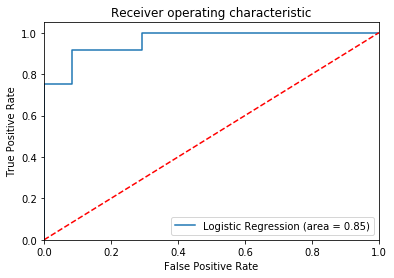

In [61]:
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
# The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.
# The support is the number of occurrences of each class in y_test.

confMatrix = confusion_matrix(y_test, y_pred)
print(confMatrix)

print(classification_report(y_test, y_pred))


logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Linear SVM without normalization
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train)  
y_pred = svclassifier.predict(X_test)  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[18  6]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        24
           1       0.65      0.92      0.76        12

   micro avg       0.81      0.81      0.81        36
   macro avg       0.80      0.83      0.80        36
weighted avg       0.85      0.81      0.81        36



In [ ]:
# Linear SVM with normalization
svclassifier = SVC(kernel='linear')  
svclassifier.fit(scl.transform(X_train), y_train)  
y_pred = svclassifier.predict(scl.transform(X_test))  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

[[18  6]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        24
           1       0.65      0.92      0.76        12

   micro avg       0.81      0.81      0.81        36
   macro avg       0.80      0.83      0.80        36
weighted avg       0.85      0.81      0.81        36



C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [ ]:
degrees =np.arange(2,11)
print(degrees)

for deg in degrees:
    svclassifier = SVC(kernel='poly', degree = deg, gamma = 'scale')  
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test)  
    print("Polynomial Degree: ", deg)
    print(confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred))  

[ 2  3  4  5  6  7  8  9 10]
Polynomial Degree:  2
[[18  6]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        24
           1       0.65      0.92      0.76        12

   micro avg       0.81      0.81      0.81        36
   macro avg       0.80      0.83      0.80        36
weighted avg       0.85      0.81      0.81        36



In [ ]:
svclassifier = SVC(kernel='poly', degree=3, gamma = 'auto', probability = True)  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)  
y_pred_prob = svclassifier.predict_proba(X_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

svclassifier = SVC(kernel='poly', degree=3, gamma = 'scale', probability = True)  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)  
y_pred_prob = svclassifier.predict_proba(X_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

In [ ]:
svclassifier = SVC(kernel='poly', degree=3, gamma = 'auto')  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

In [14]:
svclassifier = SVC(kernel='linear')  
rfe = RFECV(svclassifier)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
print(rfe.n_features_)

C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[ True  True False  True  True  True False False  True  True False False
  True]
[1 1 3 1 1 1 2 6 1 1 4 5 1]
8


In [15]:
print(rfe.grid_scores_)

[0.72272278 0.72272278 0.71592609 0.7299567  0.75079606 0.75817171
 0.79956699 0.8206898  0.81331416 0.77134595 0.77134595 0.79232101
 0.77872763]


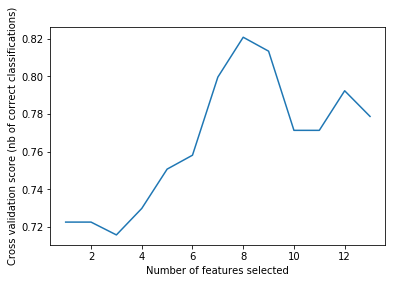

In [16]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [62]:
for n, i in enumerate(rfe.support_):
    if i:
        print(atributes[n+1])
        
logregmask = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]

print(f"\nWith LogReg Classififier:")
mainfeatures = []
for n, i in enumerate(logregmask):
    if not i:
        mainfeatures.append(n)
        continue;
    if not rfe.support_[n]:
        mainfeatures.append(n)
            
print(mainfeatures)
prim = [1,3,4,8,9,12,13]
data.head()

slope_of_peak_exercise_st_segment
thal
chest_pain_type
num_major_vessels
fasting_blood_sugar_gt_120_mg_per_dl
oldpeak_eq_st_depression
sex
exercise_induced_angina

With LogReg Classififier:
[0, 2, 5, 6, 7, 10, 11]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0z64un,1.0,1,128.0,2.0,0.0,0.0,2.0,308.0,0.0,1.0,45.0,170.0,0.0,0
ryoo3j,2.0,1,110.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,0
yt1s1x,1.0,1,125.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0,77.0,162.0,1.0,1
l2xjde,1.0,2,152.0,4.0,0.0,0.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,1
oyt4ek,3.0,2,178.0,1.0,0.0,0.0,2.0,270.0,4.2,1.0,59.0,145.0,0.0,0


In [64]:
data6 = copy.deepcopy(data)
data6.drop(axis=1, labels=mainfeatures , inplace=True)
othfeat = [0,5,6]
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0z64un,1.0,1,128.0,2.0,0.0,0.0,2.0,308.0,0.0,1.0,45.0,170.0,0.0,0
ryoo3j,2.0,1,110.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,0
yt1s1x,1.0,1,125.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0,77.0,162.0,1.0,1
l2xjde,1.0,2,152.0,4.0,0.0,0.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,1
oyt4ek,3.0,2,178.0,1.0,0.0,0.0,2.0,270.0,4.2,1.0,59.0,145.0,0.0,0


In [65]:
datan = [copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data)]
templist = [0,5,6,[0,5],[0,6],[5,6],[0,5,6]]
fet = np.arange(0,13)

for n,itm in enumerate(templist):
    if (n == 0):
        mask = np.in1d(fet, [0]+prim, invert=True)
        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 1:
        mask = np.in1d(fet, [5]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 2:
        mask = np.in1d(fet, [6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 3:
        mask = np.in1d(fet, [0,5]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 4:
        mask = np.in1d(fet, [0,6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 5:
        mask = np.in1d(fet, [5,6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 6:
        mask = np.in1d(fet, [0,5,6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
        
        
    #s = set(mainfeatures)
    #for i in [itm]:
    #    s.remove(i)
    #print(s)
    #mask = np.in1d(fet, s, invert=True)
    #print(fet[mask])
    #datan[n] = copy.deepcopy(data)
    #datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    


In [66]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0z64un,1.0,1,128.0,2.0,0.0,0.0,2.0,308.0,0.0,1.0,45.0,170.0,0.0,0
ryoo3j,2.0,1,110.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,0
yt1s1x,1.0,1,125.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0,77.0,162.0,1.0,1
l2xjde,1.0,2,152.0,4.0,0.0,0.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,1
oyt4ek,3.0,2,178.0,1.0,0.0,0.0,2.0,270.0,4.2,1.0,59.0,145.0,0.0,0


In [67]:
datan.insert(0, data6)
datan = np.array(datan)
print(datan.shape)

(8,)


In [80]:
#X, y, X_train, X_test, y_train, y_test = ( for i in range(6))
print(datan[5].head())
for i, d in enumerate(datan):
    X = d.loc[:, d.columns != 13]
    y = np.array(d.loc[:, d.columns == 13]).reshape(180,)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    svclassifier = SVC(kernel='poly', degree=3, gamma = 'auto')  
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred)) 
    print(f'Accuracy of support vector classifier on test set: {svclassifier.score(X_test, y_test)}')



         0   1    3    4    6    8    9    12  13
0z64un  1.0   1  2.0  0.0  2.0  0.0  1.0  0.0   0
ryoo3j  2.0   1  3.0  0.0  0.0  1.6  0.0  0.0   0
yt1s1x  1.0   1  4.0  3.0  2.0  0.0  1.0  1.0   1
l2xjde  1.0   2  4.0  0.0  0.0  0.0  1.0  0.0   1
oyt4ek  3.0   2  1.0  0.0  2.0  4.2  1.0  0.0   0
[[19  5]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        24
           1       0.69      0.92      0.79        12

   micro avg       0.83      0.83      0.83        36
   macro avg       0.82      0.85      0.82        36
weighted avg       0.86      0.83      0.84        36

Accuracy of support vector classifier on test set: 0.8333333333333334
[[19  5]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       0.71      1.00      0.83        12

   micro avg       0.86      0.86      0.86        36
   macro avg       0.85      0.90      0.86    